In [44]:
import fly_analysis as fa
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import circmean

In [2]:
file = "/home/buchsbaum/mnt/md0/Experiments/20240829_103302.braidz"
df, csvs = fa.braidz.read_braidz(file)

Reading /home/buchsbaum/mnt/md0/Experiments/20240829_103302.braidz using pyarrow


In [3]:
data_dict = fa.processing.extract_stimulus_centered_data(df, csvs["stim"], n_before=50, n_after=100)

<Axes: >

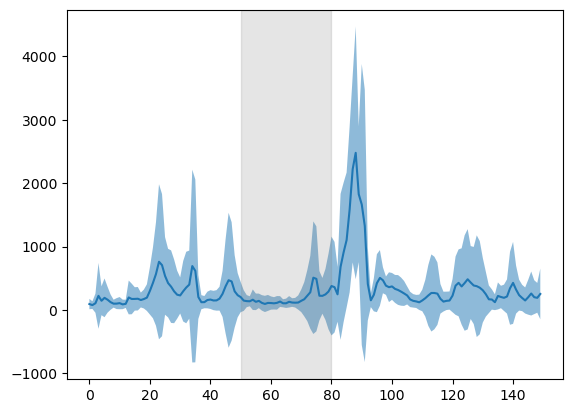

In [4]:
fa.plotting.plot_mean_and_std(np.rad2deg(data_dict["angular_velocity"]), abs_value=True, shaded_area=[50, 80])

In [63]:
pad = 25
angvels = []
stim_pos = []
turn_angles = []
heading_positions = []
difference_in_position = []

for idx, row in csvs["stim"].iterrows():
    
    # extract data
    obj_id = int(row["obj_id"])
    frame = int(row["frame"])
    pos = int(row["position"])

    # get group
    grp = df[df["obj_id"] == obj_id]

    # check if too short
    if len(grp) <= 150:
        print(f"Skipping obj_id = {obj_id}, too short")
        continue
    
    # get angular velocity and linear velocity
    xvel = grp["xvel"].values
    yvel = grp["yvel"].values
    angvel = np.gradient(np.unwrap(np.arctan2(grp.yvel.values, grp.xvel.values)), 0.01)
    linvel = np.sqrt(grp.xvel.values**2 + grp.yvel.values**2)
    heading = np.arctan2(grp.yvel.values, grp.xvel.values)

    # add padding
    padding_array = np.full(pad, np.nan)
    angvel_appended = np.concatenate((padding_array, angvel, padding_array))
    linvel_appended = np.concatenate((padding_array, linvel, padding_array))
    heading_appended = np.concatenate((padding_array, heading, padding_array))

    # get stim idx corrected for padding
    stim_idx = np.where(grp["frame"] == frame)[0][0] + pad

    start_idx = stim_idx - 50
    end_idx = stim_idx + 100

    if start_idx < 0 or end_idx >= len(angvel_appended):
        print(f"Skipping obj_id = {obj_id}, out of bounds")
        continue
    
    # calculate turning angle
    p1 = grp[["x", "y"]].iloc[80].to_numpy()
    p2 = grp[["x", "y"]].iloc[90].to_numpy()
    p3 = grp[["x", "y"]].iloc[100].to_numpy()
    
    v1 = p1 - p2
    v2 = p3 - p2

    turn_angle = np.arctan2(np.linalg.det([v1, v2]), np.dot(v1, v2))

    # calculate heading before the stimulus
    heading_angle_before_stim = circmean(heading_appended[70:80], high=np.pi, low=-np.pi)

    # interpolate to get stimulus position
    calibration = pd.read_csv("~/src/braid-opto-arena/src/stimuli/calibration.csv")
    screen = calibration["circle"].values
    heading = calibration["angle"].values
    heading_position = np.interp(heading_angle_before_stim, heading, screen, period=2 * np.pi)

    # append to lists
    angvels.append(angvel_appended[start_idx:end_idx])
    stim_pos.append(pos)
    turn_angles.append(turn_angle)
    heading_positions.append(heading_position)
    difference_in_position.append(heading_position - pos)

angvels = np.asarray(angvels)
stim_pos = np.asarray(stim_pos)
turn_angles = np.asarray(turn_angles)
heading_positions = np.asarray(heading_positions)
difference_in_position = np.asarray(difference_in_position)

Skipping obj_id = 44170, out of bounds
Skipping obj_id = 47712, out of bounds
Skipping obj_id = 51102, out of bounds
Skipping obj_id = 54125, too short
Skipping obj_id = 62652, out of bounds
Skipping obj_id = 66567, out of bounds
Skipping obj_id = 66906, out of bounds
Skipping obj_id = 67769, out of bounds


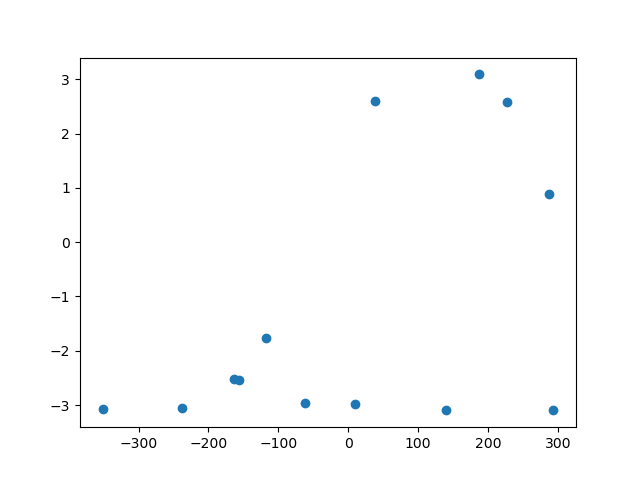

In [64]:
plt.figure()
plt.scatter(difference_in_position, turn_angles)

<Axes: >

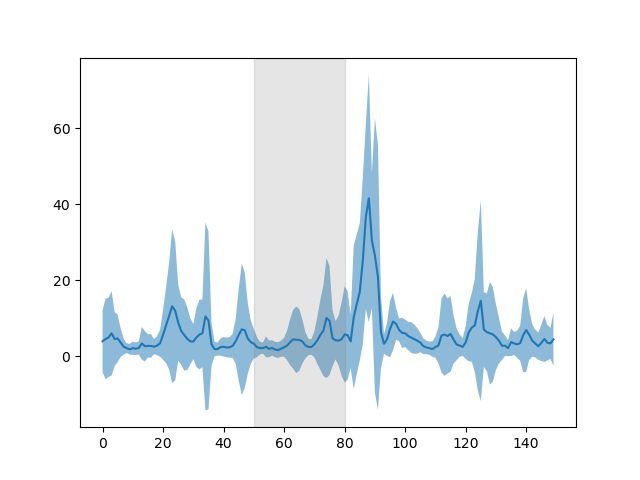

In [32]:
%matplotlib widget
fa.plotting.plot_mean_and_std(angvels, abs_value=True, shaded_area=[50, 80])